In [1]:
#add project directory to python path
import sys
sys.path.append("..")
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline
from default import PROJECT_DIRECTORY, DATA_DIRECTORY

# Clustering

In [3]:
"""
load halo catalogue
"""
import h5py
from astropy.table import Table

filepath = DATA_DIRECTORY
filename = 'mdr1_fof_va.hdf5'
f = h5py.File(filepath+filename,'r')
dset = f['data']
d = {key: dset[key] for key in dset.dtype.names}
halo_table = Table(d)
print(halo_table.keys())

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #MDR1 cosmology
Lbox = np.array([1000.0]*3)

m_part = 8.721*10**9 #particle mass
n_part = int(10**13/m_part) #number of particles in 10^13 Msol halo

#use z-component of velocities
core_keys = ['vz_central_ptcl','vz_inner01','vz_inner10',
             'vz_inner20','vz_inner30','vz_inner40',
             'vz_inner50','vz_inner60','vz_inner70',
             'vz_inner80','vz_inner90']
cores = np.array([1/n_part,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

['vx_inner50', 'vx_inner70', 'rowid', 'vz_inner30', 'vy_inner50', 'vz_inner70', 'vy_inner10', 'vz_inner50', 'vy_inner70', 'vy_inner30', 'vx_inner90', 'haloid', 'vx', 'vy', 'vz', 'vx_central_ptcl', 'size', 'vz_std', 'vy_inner90', 'vz_inner80', 'vz_all', 'vx_inner20', 'vx_inner60', 'vx_inner01', 'vx_std', 'vy_inner40', 'vx_inner40', 'vz_inner40', 'vz_inner20', 'vz_inner60', 'vz_central_ptcl', 'vy_inner60', 'vy_all', 'vz_inner10', 'vy_central_ptcl', 'vx_inner80', 'vy_std', 'vz_inner90', 'vx_all', 'vy_inner80', 'vy_inner20', 'vx_inner30', 'mass', 'vz_inner01', 'y', 'x', 'z', 'vx_inner10', 'vy_inner01']


In [4]:
"""
put the haloes in redshift space
"""

from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import s_mu_tpcf

halo_velocity_key = 'vz_inner10'

coords = return_xyz_formatted_array(halo_table['x'],halo_table['y'],halo_table['z'],
                                    velocity=halo_table[halo_velocity_key],
                                    period=Lbox, velocity_distortion_dimension='z')

In [5]:
"""
calculate the tpcf in s and mu bins
"""

#Define s bins
s_bins = np.logspace(0,np.log10(75),40)
s_bin_centers = (s_bins[:-1]+s_bins[1:])/(2.0)

#Define mu bins
mu_bins = np.linspace(0.0,1.0,100) 
mu_bin_centers = (mu_bins[:-1]+mu_bins[1:])/(2.0)
    
#Calculate TPCF
import time
start = time.time()
result = s_mu_tpcf(coords, s_bins=s_bins, mu_bins=mu_bins, period=Lbox, num_threads=4)
print("time to compute: ", time.time()-start)

time to compute:  12.3338830471


In [7]:
"""
calculate the multipoles of the tpcf
"""

from halotools.mock_observables import tpcf_multipole

tpcf_l_0 = tpcf_multipole(result, mu_bins, order=0)
tpcf_l_2 = tpcf_multipole(result, mu_bins, order=2)
tpcf_l_4 = tpcf_multipole(result, mu_bins, order=4)

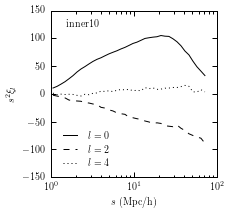

In [29]:
"""
plot the multipoles
"""

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(s_bin_centers, tpcf_l_0*s_bin_centers**2, '-', color='black')
l2, = plt.plot(s_bin_centers, tpcf_l_2*s_bin_centers**2, '--', color='black')
l3, = plt.plot(s_bin_centers, tpcf_l_4*s_bin_centers**2, ':', color='black')
plt.ylabel(r'$s^2\xi_l$')
plt.xlabel(r'$s ~({\rm Mpc/h})$')
plt.xscale('log')
plt.xlim([1,100])
plt.ylim([-150,150])
plt.legend([l1,l2,l3],[r'$l=0$',r'$l=2$',r'$l=4$'], fontsize=10, loc='lower left', frameon=False)
plt.text(1.5, 120, halo_velocity_key.split('_')[1], fontsize=10)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'multipoles_'+halo_velocity_key
fig.savefig(filepath + filename + '.pdf', dpi=300)
fig.savefig(filepath + filename + '.png', dpi=300)

In [30]:
from astropy.table import Table

t = Table([s_bin_centers, tpcf_l_0, tpcf_l_2, tpcf_l_4], names=('s', 'l=0', 'l=2', 'l=4'))

filepath = '/Users/duncan/Desktop/'
filename = 'multipoles_'+halo_velocity_key
t.write(filepath + filename + '.dat', format='ascii')